# 6 [20 points] Critical Slowing Down

**LI, YI-QUAN(Eric)** and **Jenish**

**uni-ID:s08yli** and **s6jeadhi**

**github-address: https://github.com/LeeYee2002/Computational-Physics-HW.git**

Let the external magnetic field h = 0. The model is essentially indistinguishable from before:

\begin{align}
    Z[\beta,J] &= \sum_{\sigma} e^{-\beta H[J]}
    &
    H[J] &= -J\sum_{<\vec{x},\vec{y}>} \sigma_{\vec{x}} \sigma_{\vec{y}}
    &
    \beta = & \frac{1}{T}
\end{align}

To pick a set of dimensionless units we can set β = 1.
The transition happens at the critical coupling:

\begin{align}
    J_c = & \frac{1}{2} \log{(1 + \sqrt{2})} \approx 0.4406867935097715···
\end{align}
The net magnetization $M=\sum_{\vec{x}} \sigma_{\vec{x}}$, and the magnetization per site is m = $\frac{1}{N^2} M$ M. In 1948On sager twice stated at conferences without proof that in the thermodynamic limit:

\begin{equation}
    \langle |m| \rangle = \begin{cases}
    0, & J   \leq J_c & \text{(warmer than critical)}\\
    (1 - \frac{1}{\sinh^4{(2J)}})^{\frac{1}{8}}, & J >  J_c & \text{(cooler than critial)}.
    \end{cases}
\end{equation}

We also know the energy per site:

\begin{align}

    \epsilon = -J \coth(2J) \{1+\frac{2}{\pi}(2\tanh^2(2J)−1)× K(4 \operatorname{sech} ^2(2J)\tanh^2(2J))\}
    
\end{align}

where K is the complete elliptic integral of the first kind,

\begin{align}

K(k^2) = \int^\frac{\pi}{2}_0 \frac{d\theta}{\sqrt{1-k^2 \sin^2{\theta}}}

\end{align}

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import random

global J_c 
J_c = 0.5*np.log(1+ 2**0.5) #J_c = 0.4406867935097715···

In [19]:
#expectation of |m|
def average_m(J):
    return_J = np.empty_like(J)
    for i in range(J.size):
        if J[i] > J_c:
            return_J[i]=(1- 1/(np.sinh(2*J[i])**4))**0.125
    else:
        return_J[i] = 0
    return return_J
#epsilon 
def eps(J):
    epsilon = -J/np.tanh(2*J)*( 1 + (2/np.pi)*( 2* np.tanh(2*J)**2-1 ) * K(4*np.cosh(2*J)**-2 * np.tanh(2*J)**2) )
    return epsilon
#K integral
def K(k_square):
    #print(type(k_square))
    if isinstance(k_square ,np.ndarray) or isinstance(k_square, list):
        k_square_element = []
        for member in k_square:
            integrand = lambda x : 1/np.sqrt(1-member*np.sin(x)**2)
            a = 0.
            b = np.pi/2
            result, error = spi.quad(integrand, a, b)
            #print('Result is ', result, 'with error ', error)
            k_square_element.append(result)
        return np.array(k_square_element)
    else:
        integrand = lambda x : 1/np.sqrt(1-k_square*np.sin(x)**2)
        a = 0.
        b = np.pi/2
        result, error = spi.quad(integrand, a, b)
        return result


### 6.1 [5 points] Spontaneous Magnetization

**(2 points) Do an MCMC simulation with N = 4 for J ∈ {0.1,0.2,Jc,0.7,0.8}. Pick a starting configu
ration that is checkerboarded with +1s and −1s, so that the starting m is close to 0. Make a histogram that shows the respective frequency of |m|.**

As HW1-5 shows, we will make, less independent experiment and longer experimnt time(longer enough to thermalize.)

In [20]:
#1D=H conputation
def compute_H_1d(J,sigma_1d):
    h_1d = sigma_1d[0]*sigma_1d[-1]
    for i in range(sigma_1d.shape[0]-1):
        h_1d += sigma_1d[i]*sigma_1d[i+1]
    h_1d *=- J
    return h_1d
#we suppose sigma is n*m(here N*N) 2D torus 
def compute_H_2d(J,sigma_2d):
    h_2d = 0
    row_num, col_num = sigma_2d.shape
    for i in range(row_num):
        h_2d += compute_H_1d(J, sigma_2d[i])
    for j in range(col_num):
        h_2d += compute_H_1d(J,sigma_2d[:,j])
    return h_2d

#delta H : input(J,sigma,point(tuple))

def delta_H(J,sigma,point):
    x,y = point
    row_num, col_num = sigma.shape
    d_H = 0
    d_H = 2*J*sigma[x,y]*( sigma[(x+1) % row_num,y] +sigma[(x-1)% row_num ,y] + sigma[x,(y+1) % col_num] + sigma[x,(y-1) % col_num] )
    return d_H

In [21]:
#define M and m
def compute_M_m(sigma_2d):
    row_num, col_num = sigma_2d.shape
    M, m = 0., 0.
    for i in range(row_num):
        for j in range(col_num):
            M += sigma_2d[i][j]
    m = M/(row_num*col_num)
    return M, m
#create a sweep design. Initially, we use i,j loop, such Cartasin product is in order. Now we shuffle each i,j, to make a new Cartasian product space
def sweep_2d(row, col):
    #then we wrap our product space with tuple (i,j)
    sweep_list = []
    sweep_order_i = np.arange(0,row) 
    np.random.shuffle(sweep_order_i) # shuffle it
    sweep_order_j = np.arange(0,col)
    np.random.shuffle(sweep_order_j) #shuffle it
    for i in sweep_order_i:
        for j in sweep_order_j:
            sweep_list.append((i,j))
    random.shuffle(sweep_list)
    return sweep_list
#to be more comfortable, we introduce function to define one time revolution
def two_d_MCMC_revolution(j_value,lattice,size):
    sweep_target_list = sweep_2d(size,size)
    for i,j in sweep_target_list:
            update_probability = np.random.uniform(0,1)
            acception_chance = np.e**(-1*delta_H(j_value,lattice,(i,j)))
            if delta_H(j_value,lattice,(i,j)) < 0:
                lattice[i,j] *= -1
            else:
                if update_probability < acception_chance:
                    lattice[i,j] *= -1
    return lattice
#turn every thing to checkboard
def checkboard(lattice,size):
    #00 01 02 03 + - + -
    #10 11 12 13 - + - +
    #20 21 22 23 + - + -
    #30 31 32 33 - + - +
    for i in range(size):
        for j in range(size):
            if (i+j) % 2 ==1:
                lattice[i,j]*=-1
    return lattice

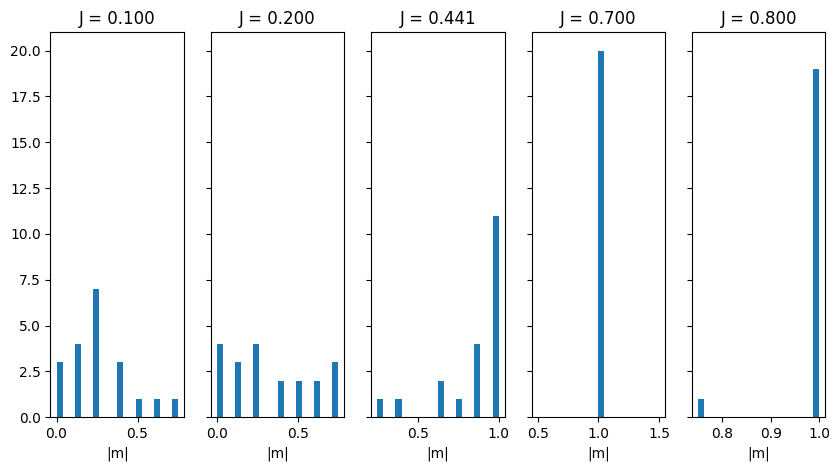

In [9]:
## MCMC 2D Ising Model 
N = 4   #size of sample(N^2)
list_J = [0.1, 0.2, J_c, 0.7, 0.8] #the coupling of J
external_h = 0 #from the premise of the exercise this time.
samples = 1000 #number of times we go through revolution
experiments = 20 #numbers of experiments we make

#net_magnetisation = []     # M
average_magnetisation_abs = np.zeros(20)
#print(average_magnetisation_abs)
#for latter question:
abs_m_N_equal_4 = []

fig, axs = plt.subplots(1, 5,figsize=(10,5),sharey=True,sharex=False)



for this_J in list_J:
    index = list_J.index(this_J)
    lattice = np.ones((N,N))
    #print(index)
    checkboard(lattice,N)
    for i in range(experiments):
        for j in range(samples):
            lattice = two_d_MCMC_revolution(this_J,lattice,N)
            #go through revolution
        _M, _m = compute_M_m(lattice)
        average_magnetisation_abs[i] = abs(_m)
        #print(average_magnetisation_abs)

    #insert to figure
    axs[index].hist(average_magnetisation_abs,bins=20,density=False)
    axs[index].set_title(f"J = {this_J:.3f}")
    axs[index].set_xlabel("|m|")
    abs_m_N_equal_4.append(np.copy(average_magnetisation_abs))
    #end insert
plt.show()



**(1 point) Do it again for N = 8 and N = 12**

N = 8

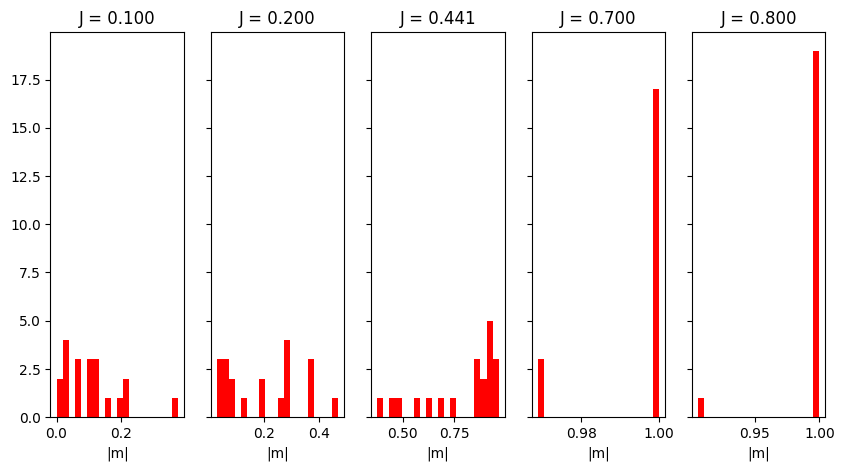

In [10]:
## MCMC 2D Ising Model 
N = 8   #size of sample(N^2)
list_J = [0.1, 0.2, J_c, 0.7, 0.8] #the coupling of J
external_h = 0 #from the premise of the exercise this time.
samples = 1000 #number of times we go through revolution
experiments = 20 #numbers of experiments we make

#net_magnetisation = []     # M
average_magnetisation_abs = []
abs_m_N_equal_8 = []

fig, axs = plt.subplots(1, 5,figsize=(10,5),sharey=True,sharex=False)



for this_J in list_J:
    index = list_J.index(this_J)
    lattice = np.ones((N,N))
    #print(index)
    checkboard(lattice,N)
    for i in range(experiments):
        for j in range(samples):
            lattice = two_d_MCMC_revolution(this_J,lattice,N)
            #go through revolution
        _M, _m = compute_M_m(lattice)
        average_magnetisation_abs.append(abs(_m))
        #print(average_magnetisation_abs)

    #insert to figure
    axs[index].hist(average_magnetisation_abs,bins=20,density=False, color = "r")
    axs[index].set_title(f"J = {this_J:.3f}")
    axs[index].set_xlabel("|m|")
    abs_m_N_equal_8.append(average_magnetisation_abs.copy())
    average_magnetisation_abs.clear()
    #end insert
plt.show()

N = 12

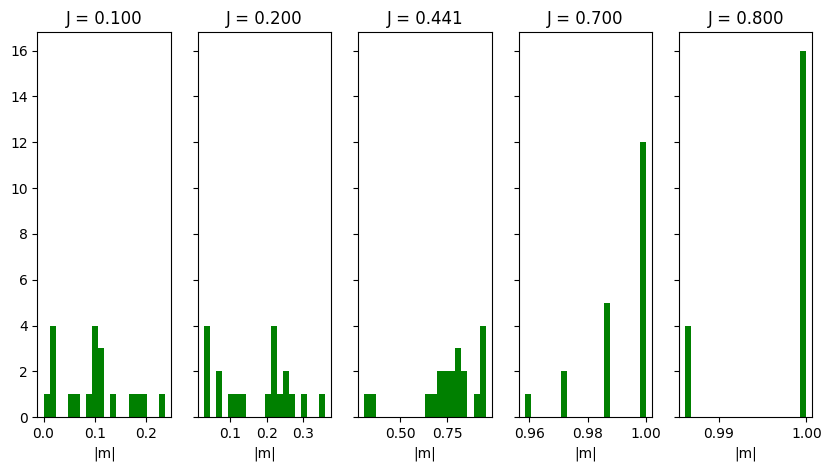

In [11]:
## MCMC 2D Ising Model 
N = 12   #size of sample(N^2)
list_J = [0.1, 0.2, J_c, 0.7, 0.8] #the coupling of J
external_h = 0 #from the premise of the exercise this time.
samples = 1000 #number of times we go through revolution
experiments = 20 #numbers of experiments we make


#net_magnetisation = []     # M
average_magnetisation_abs = []
abs_m_N_equal_12 = []

fig, axs = plt.subplots(1, 5,figsize=(10,5),sharey=True,sharex=False)



for this_J in list_J:
    index = list_J.index(this_J)
    lattice = np.ones((N,N))
    #print(index)
    checkboard(lattice,N)
    for i in range(experiments):
        for j in range(samples):
            lattice = two_d_MCMC_revolution(this_J,lattice,N)
            #go through revolution
        _M, _m = compute_M_m(lattice)
        average_magnetisation_abs.append(abs(_m))
        #print(average_magnetisation_abs)

    #insert to figure
    axs[index].hist(average_magnetisation_abs,bins=20,density=False, color = "g")
    axs[index].set_title(f"J = {this_J:.3f}")
    axs[index].set_xlabel("|m|")
    abs_m_N_equal_12.append(average_magnetisation_abs.copy())
    average_magnetisation_abs.clear()
    #end insert
plt.show()



**(1 point) Using the already-generated ensembles, overlay the histograms for the different N at fixed J(one histogram per J).**

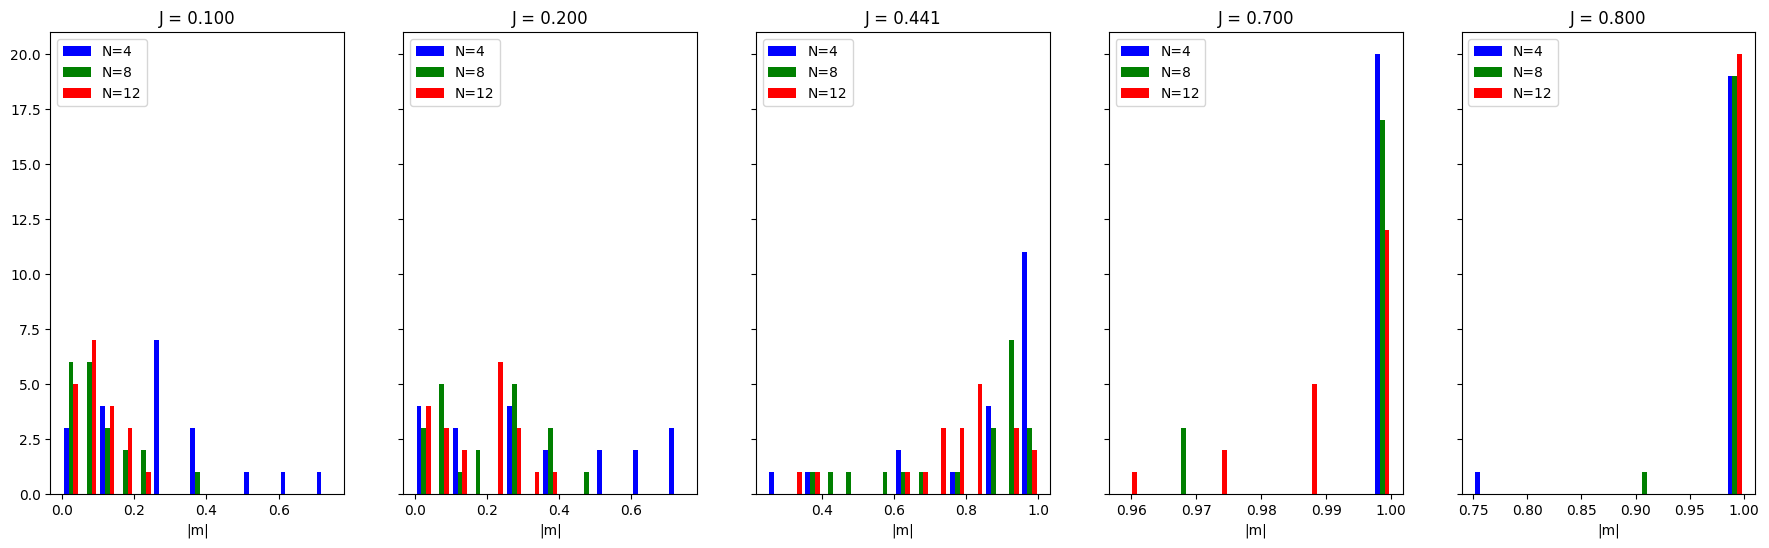

In [13]:
N = [4, 8, 12]
J = [0.1, 0.2, J_c, 0.7, 0.8]
fig, axs = plt.subplots(1, 5,figsize=(22,6),sharey=True,sharex=False)
for this_J in J:
    index = J.index(this_J)
    colors = ['b','g','r']
    hist_labels = ["N=4","N=8","N=12"]
    hist_data = np.empty(shape=(20,3))
    hist_data[:,0] =abs_m_N_equal_4[index]
    hist_data[:,1] =abs_m_N_equal_8[index]
    hist_data[:,2] =abs_m_N_equal_12[index]
    axs[index].hist(hist_data,bins= 15, color = colors,density=False, label=hist_labels)
    axs[index].set_title(f"J = {this_J:.3f}")
    axs[index].set_xlabel("|m|")
    axs[index].legend(loc="upper left")
plt.show()

**(1 point) Write a few sentences explaining the different tendencies as N grows. Can you see evidence for the thermodynamic limit? Of spontaneous magnetization?**

With the same revolution time(1000), we found for larger N, the value |m| seems to be increase at larger J. 
We can see after J value over $J_c$, it turns out to have tendencies to have |m| ≠ 0.

### 6.2 [5 points] Scanning J
**Perform importance-sampling via MCMC for $J^{−1}$ ∈ {1.0,1.1,1.2,··· ,3.9,4.0} (a total of 31 different Js) for N ∈{4,8,12}, generating at least 2000 configurations each time. Do some sort of uncertainty estimation, measuring |m| and ϵ.You’ll reuse these ensembles below**

In [14]:
ins_J = np.linspace(1.0,4.0,31)
case_N = [4,8,12]

configurations = 2000
samples = 20

#print(ins_J)

resulting_abs_m = np.zeros(shape = (3,31,samples)) #store |m| values 
resulting_abs_m_average = np.zeros(shape=(3,31,2))
resulting_e = np.zeros(shape = (3,31,samples)) #store epsilon
resulting_e_average = np.zeros(shape=(3,31,2))

for i in range(31): #different J
    this_J = ins_J[i]
    for j in range(3):# N =4,8,12
        N = case_N[j]
        for test in range(samples):
            lattice = np.ones((N,N))
            checkboard(lattice,N)
            for running in range(configurations):
                #go through revolution
                lattice = two_d_MCMC_revolution(1/this_J,lattice,N)
                
            _M, _m = compute_M_m(lattice)
            _e = compute_H_2d(1/this_J,lattice)/N**2
            resulting_abs_m[j,i,test]=(abs(_m))
            resulting_e[j,i,test] = _e
        #print(average_magnetisation_abs)
            

**(2 points) Plot |m| with error bars indicating uncertainty as a function of $J^{−1}$ (which is like T) over the exactly-known result.**

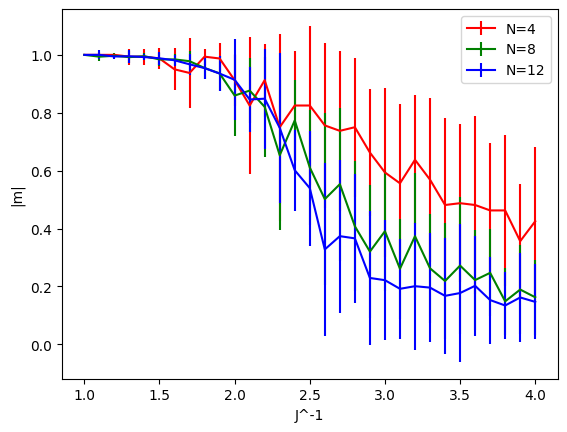

In [16]:
for i in range(3):
    for j in range(31):
        resulting_abs_m_average[i,j,0] = np.average(resulting_abs_m[i,j])
        resulting_abs_m_average[i,j,1] = resulting_abs_m[i,j].std()
        resulting_e_average[i,j,0] = np.average(resulting_e[i,j])
        resulting_e_average[i,j,1] = resulting_e[i,j].std()

plt.errorbar(ins_J,resulting_abs_m_average[0,:,0], yerr=resulting_abs_m_average[0,:,1],color= "r",label='N=4')
plt.errorbar(ins_J,resulting_abs_m_average[1,:,0],yerr=resulting_abs_m_average[1,:,1],color= "g",label='N=8')
plt.errorbar(ins_J,resulting_abs_m_average[2,:,0],yerr=resulting_abs_m_average[1,:,1],color= "b",label='N=12')
plt.xlabel("J^-1")
plt.ylabel("|m|")
plt.legend()
plt.show()


**(2 points) Plot ϵ/J with uncertainties as a function of $J^{−1}$ over the exactly-known result (don’t miss the /J!)**

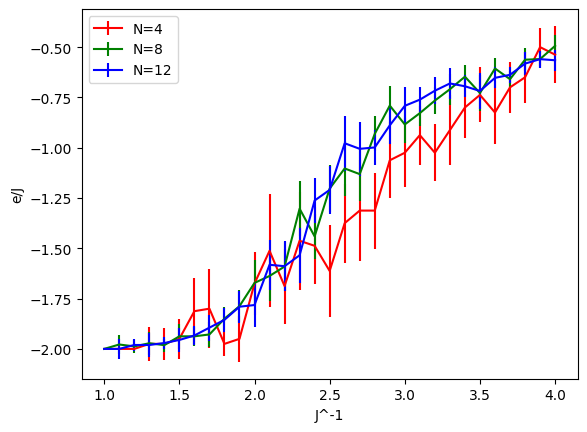

In [17]:
plt.errorbar(ins_J,resulting_e_average[0,:,0]*ins_J, yerr=resulting_e_average[0,:,1],color= "r",label='N=4')
plt.errorbar(ins_J,resulting_e_average[1,:,0]*ins_J,yerr=resulting_e_average[1,:,1],color= "g",label='N=8')
plt.errorbar(ins_J,resulting_e_average[2,:,0]*ins_J,yerr=resulting_e_average[1,:,1],color= "b",label='N=12')
plt.xlabel("J^-1")
plt.ylabel("e/J")
plt.legend()
plt.show()


**(1 point) Even though we know we have severe tunneling problems in the broken phase, these (should) come out basically OK. Explain this observation**

We might see the tnflection point around crital point, which is about $J_c = 0.44$ such $1/J_c \approx 2.3$, and for larger J(cool condition) the |m| will tend to be 1.

### 6.3 [5 points] The Spin-Spin Correlation Function

**A two-point correlation function is an observable that depends on two spatial coordinates. The energy is built out of nearest-neighbor pairs, so is built from little short-range two-point functions.The spin-spin two-point correlation function is:**
$$C_{xy} = ⟨σ_x σ_y⟩$$
**for all pairs of sites x and y (not just nearest neighbors). By translational invariance (leveraging pbcs) only the difference between x and y can matter, so we can define**
$$C(∆x) = \frac{1}{Λ} \sum_x C_{x,x+∆x}$$
**where $Λ = N^2$ is the 2-dimensional volume (number of sites).**

**(1 point) What value should C(0) take?**

It should be one since every point is either +1 or -1, the product of itself will be 1 anyway. For $N^2$ point, we will have sum of all product = $N^2$, the average of it is $C(0) =\frac{N^2}{N^2} =1 $

**(2 points) Implement it using Fourier acceleration (as in Exercise 4.3, but in 2 dimensions). Check your implementation produces the expected value at ∆x = 0.**

In [18]:
#C(dx,dy)
def autocorrelation(lattice,size):
    N = size
    C = np.fft.ifft2(np.fft.fft2(lattice) * np.fft.ifft2(lattice)).real
    return C
#we set dx => dy we only see first row
#there will be simple addition for different distance.
def flatten_to_1d(C_2_d,size):
    C_1_d = np.zeros(size)
    for j in range(size):
        C_1_d[j]+=C_2_d[0,j]
    return C_1_d


In [19]:
#simple test
a=np.ones((5,5))
a=checkboard(a,5)
b = autocorrelation(a,5)
print(b)
c = flatten_to_1d(b,5)
print(c)

[[ 1.   -0.6   0.2   0.2  -0.6 ]
 [-0.6   0.36 -0.12 -0.12  0.36]
 [ 0.2  -0.12  0.04  0.04 -0.12]
 [ 0.2  -0.12  0.04  0.04 -0.12]
 [-0.6   0.36 -0.12 -0.12  0.36]]
[ 1.  -0.6  0.2  0.2 -0.6]


In [20]:
N = 12
sample = 100
j_this = 0.5
two_d_lattice = checkboard(np.ones((N,N)),N)

for j in range(samples):
    two_d_lattice = two_d_MCMC_revolution(j_this,two_d_lattice,N)
print(flatten_to_1d(autocorrelation(two_d_lattice,5),5)) #index 0 means dx =0




[1.         0.86111111 0.83333333 0.83333333 0.83333333]


Actually we verify two things, firstly is the cold condition(J>$J_c$), so we almost got a flat line; secondly is we got C(0) = 1 by no means.

**(2 points) For each N (make 3 figures), plot the correlation function with uncertainties for $J^{−1}$ ∈ {1.0, 2.0,3.0,4.0} as a function of ∆x. You can flatten it into a 1-dimensional figure, draw a 2- or 3-dimensional figure, whatever you think gets the message across.**

In [21]:
print(np.random.choice(40,20))

[11  4  7 19 22 19  9 18  6 38  5 32 38  7 17 18 39 10  3  1]


In [22]:
class Two_D_lattice:
    def __init__(self,N,J):
        self.size = N
        self.J_val = J
        self.sample = []#20 samples
        self.configuration = 2000
        self.resulting_correlation = np.zeros(N) #
        for i in range(20):#20 samples
            self.sample.append(checkboard(np.ones((self.size,self.size)),self.size))
        for member in self.sample:
            for i in range(self.configuration):
                member = two_d_MCMC_revolution(self.J_val,member,self.size)
    def bootstrap_in_it(self):
        decimated_data = self.sample[::2]#left 10 configuration
        #randomly take 5 data, we repeat 10 times
        repeat_sample = np.zeros_like(self.resulting_correlation)
        for i in range(10):
            this_draw = np.random.choice(10,5) #upbound, number of draw
            function_buffer = np.zeros_like(self.resulting_correlation)
            for config in this_draw:
                two_d_C = autocorrelation(decimated_data[config],self.size)
                one_d_C = flatten_to_1d(two_d_C,self.size)
                function_buffer = function_buffer+ one_d_C/5
                #20 correlation function we have for 10 times, got evergy 
            repeat_sample = repeat_sample+function_buffer/10
        self.resulting_correlation = repeat_sample 

In [23]:

invers_J = np.linspace(1.0,4.0,4)
list_N = [4, 8, 12]
case_list = [] #we will have 3*4 member for different N and J
for i in range(3):
    buffer_lst = [] #contain differnt J
    for j in range(4):
        n = list_N[i]
        this_J = 1/invers_J[j]
        buffer_lst.append(Two_D_lattice(n,this_J))
    case_list.append(buffer_lst)

Now we have our ensembles, we have our bootstrap, and calculate C.

In [24]:
for i in range(3):
    for j in range(4):
        case_list[i][j].bootstrap_in_it()

Now we plot:

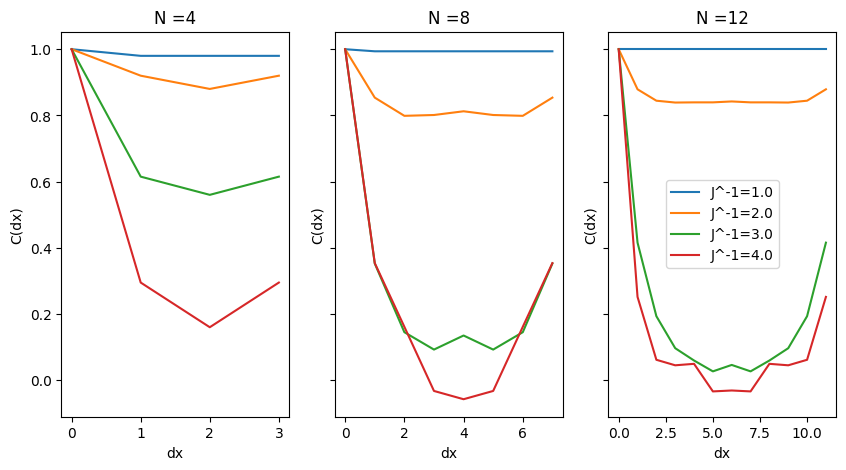

In [25]:
fig, axs = plt.subplots(1, 3,figsize=(10,5),sharey=True,sharex=False)

for this_N in list_N:
    index_N = list_N.index(this_N)
    dx = np.arange(this_N)
    axs[index_N].set_title(f"N ={this_N}")
    axs[index_N].set_xlabel("dx")
    axs[index_N].set_ylabel("C(dx)")
    for j in range(4):
        axs[index_N].plot(dx,case_list[index_N][j].resulting_correlation,label=f'J^-1={invers_J[j]}')
        
plt.legend()
plt.show()


It seems that the size will impact the fluctuation of the system autocorrelation function, the larger size tend to have deeper minimium in the function. And for the case J <$J_C$ (or $1/J > 1/J_C$), the autocorrelation function will tend to approach 0 in any case.
Last, we found at the half of the system size has the most impact, so each local min(or golbal Min) shows on the midle distance. 

### 6.4 [5 points] The Dynamical Exponent

**The dynamical exponent z of a sampling algorithm for a physical system is defined through**
$$τ ∝ξ^z$$
**where τ is the integrated autocorrelation time (a property of the Markov chain, and therefore algorithm dependent) and ξ is the correlation length (an algorithm-independent property of the physics itself), and z indicates how well the proposal scheme makes big acceptable changes to the configurations (ie. how well it takes us through the whole probability space). Assuming C ∼ #e−∆x/ξ, we can isolate ξ by computing**
 
$$
\xi = -\frac{1}{\partial \Delta x} \log C(\Delta x)
$$

**or, equivalently:**

$$

\xi = -\frac{C(\Delta x)}{\partial \Delta x \, C(\Delta x)}
$$


**though which is more stable numerically may be context-dependent.**

**In this section you don’t have to do any error analysis; just the gist is good enough. Focus on C projected along one of the two axes of the lattice, so that we can think of it as one dimensional**

**(2 points) Actually, as written ξ depends on ∆x. Implement one of formulations of the correlation length ξ (9), using one or the other right-hand sides.**

We choose the latter term.

In [26]:
def xi(C_1_d,dx):
    #by periodic boundary, I assume C(dx + l) =C(dx) for 0<=dx<l
    ind = int(dx)
    array_cp = np.copy(C_1_d)
    period = C_1_d.shape[0]
    a=int((ind+1)%period)
    b=int(ind%period)
    xi_val = -1*array_cp[ind]*(array_cp[a]-array_cp[b])**-1
    return xi_val

**ξ is only truly a constant on a pure exponential. This provides a good way to test if you’ve got your implementation right: put in a made-up pure-exponential-decay and see that you get out what you put in. However, real data is more complicated. Take as the ‘true’ ξ the value half-way between the origin (∆x = 0) and the boundary (∆x = N/2, for the one-dimensional projection).**

**(2 points) Compute ξ in this way on every ensemble you’ve got. Plot $τ_m$, the integrated autocorrelation time for the observable m (enforcing that ⟨m⟩ = 0 no matter what the sample average is) against ξ.**

In [27]:
#autocorrelation function C
import numpy as np
def autocorrelation_t(timeseries, mean=None):
    if mean is None:
        mean = timeseries.mean()
        #print(mean)
        fluctuations = timeseries-mean
        C = np.fft.ifft(np.fft.fft(fluctuations) * np.fft.ifft(fluctuations)).real
    return C/C[0]
#integrated value: tau
def integrated_autocorrelation_time(timeseries,mean=None):
    #if any(autocorrelation(timeseries)<0):
    #    print("there is 0")
    Gamma = autocorrelation_t(timeseries)
    first_zero = np.where(Gamma <= 0)[0][0] #T should be choosen to first zero
    #print(first_zero)
    tau = 0.5 +  Gamma[1:first_zero].sum()
    #print(tau)
    return tau

In [32]:
#modified our class
class Two_D_lattice_record_m:
    def __init__(self,N,J):
        self.size = N
        self.J_val = J
        self.samples = []
        self.configuration = 2000
        self.resulting_correlation = np.zeros(N) #
        self.m = np.zeros((20,2000))##high light it ,we will use it to record m and calculate autocorrelation time
        self.tau = np.zeros(20)
        self.xi = 0
        for i in range(20):
            self.samples.append(checkboard(np.ones((self.size,self.size)),self.size))
        ind = 0
        for member in self.samples:
            for i in range(self.configuration):
                member = two_d_MCMC_revolution(self.J_val,member,self.size)
                _M, _m = compute_M_m(member)
                self.m[ind,i] = _m
            ind+=1
    def bootstrap_in_it(self):
        decimated_data = self.samples[::2]#left 10 configuration
        #randomly take 5 data, we repeat 10 times
        repeat_sample = np.zeros_like(self.resulting_correlation)
        for i in range(10):
            this_draw = np.random.choice(10,5)
            function_buffer = np.zeros_like(self.resulting_correlation)
            for config in this_draw:
                two_d_C = autocorrelation(decimated_data[config],self.size)
                one_d_C = flatten_to_1d(two_d_C,self.size)
                function_buffer = function_buffer+ one_d_C/5
                #20 correlation function we have for 20 times, got evergy 
            repeat_sample = repeat_sample+function_buffer/10
        self.resulting_correlation = repeat_sample
    def get_tau(self):
        for i in range(20):
            self.tau[i] = integrated_autocorrelation_time(self.m[i],mean = 0)# we force to 
    def get_xi(self):
        if self.size%2 ==0:
            #print(self.resulting_correlation)
            a = xi(self.resulting_correlation,self.size/2)
            b = xi(self.resulting_correlation,(self.size/2-1))
            self.xi =( a + b )/2
        else:
            self.xi = xi(self.resulting_correlation,(self.size+1)/2)


Do it again:

In [33]:
invers_J = np.linspace(1.0,4.0,4)
list_N = [4, 8, 12]
case_list_new = [] #we will have 3*4 member for different N and J
for i in range(3):
    buffer_lst = [] #contain differnt J
    for j in range(4):
        n = list_N[i]
        this_J = 1/invers_J[j]
        buffer_lst.append(Two_D_lattice_record_m(n,this_J))
    case_list_new.append(buffer_lst)

In [34]:
for i in range(3):
    for j in range(4):
        case_list_new[i][j].bootstrap_in_it()
        case_list_new[i][j].get_tau()
        case_list_new[i][j].get_xi()

C:\Users\88697\AppData\Local\Temp\ipykernel_15860\253545522.py:8: RuntimeWarning: divide by zero encountered in scalar power
  xi_val = -1*array_cp[ind]*(array_cp[a]-array_cp[b])**-1


0.8185411772234465 -inf
85.1527445518963 -inf
4.830460821820169 0.4999999999999999
1.3572763432503068 0.5
3.0205694844300455 -inf
121.0782361373999 -inf
5.5205877501723535 0.5
1.3727884233805945 0.5
14.131561184736025 -inf
25.188764815802465 0.5
6.366675670833094 0.49999999999999994
1.4155091501461738 0.5000000000000003


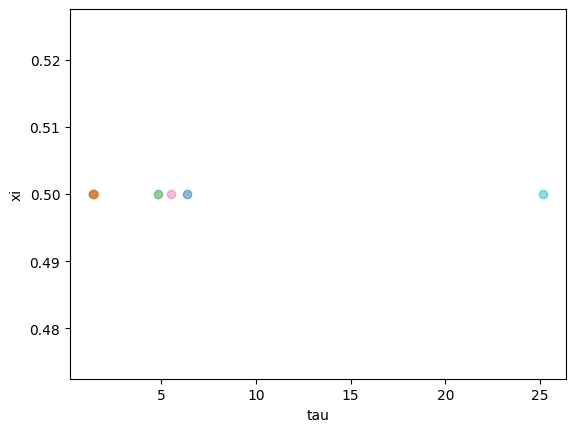

In [37]:
for this_N in list_N:
    index_N = list_N.index(this_N)
    plt.xlabel(r"$\tau$")
    plt.ylabel(r"$\xi$")
    for j in range(4):
        plt.scatter(np.average(case_list_new[index_N][j].tau),case_list_new[index_N][j].xi,alpha=0.5,)
        print(np.average(case_list_new[index_N][j].tau),case_list_new[index_N][j].xi)
plt.show()


Unfortunately, there might be somthing wrong about my simulation, but I could not find it.

In [ ]:
index = list_J.index(0.8)

In [ ]:
index

4